In [ ]:
!pip install textblob
!pip install tweepy
!python -m textblob.download_corpora

In [ ]:
!pip install google_trans_new

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as keras; 
import tensorflow as tf;
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import tweepy
import numpy as np
import re
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.utils import to_categorical 
from sklearn.preprocessing import LabelEncoder
from datetime import date, datetime, timedelta
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping


print("Versão Keras :" , keras.__version__)
print("Versão Tensorflow :" , tf.__version__)

Versão Keras : 2.3.0-tf
Versão Tensorflow : 2.2.0


### Criando o dataframe para ser usado

In [74]:
# Funcao para limpar os tweets
def cleanTxt(text):
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    text = re.sub('#', '', text) # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
    return text

# Funcao para pegar subjectivity
# SUBJECTIVITY: que também é um valor contínuo que varia de 0.0 a 1.0, sendo 0.0 referente a 100% objetivo e 1.0 a 100% subjetivo.
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Funcao para pegar  polarity
# POLARITY: é um valor contínuo que varia de -1.0 a 1.0, sendo -1.0 referente a 100% negativo e 1.0 a 100% positivo.
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getSentimento(score):
    if score < 0:
        return 'Negativo'
    elif score == 0:
        return 'Neutro'
    else:
        return 'Positivo'


In [3]:
credentials = pd.read_csv("../../../../data/classificacao de sentimento/credentials.csv")

In [75]:
# Twitter Api Credentials
consumerKey = credentials['Api_key'][0]
consumerSecret = credentials['Api_key_secret'][0]
accessToken = credentials['access_token'][0]
accessTokenSecret = credentials['access_token_secret'][0]

In [5]:
# Create the authentication object
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret) 
    
# Set the access token and access token secret
authenticate.set_access_token(accessToken, accessTokenSecret) 
    
# Creating the API object while passing in auth information
api = tweepy.API(authenticate, wait_on_rate_limit = True)

In [6]:
# Pegando os ultimos 1000 tweet (limitado a 200 tweets por chamada)
tweets = []
for status in tweepy.Cursor(api.user_timeline, screen_name='@joebiden', tweet_mode="extended").items():
    tweets.append(status.full_text)
    if len(tweets) == 1000:
        break
df = pd.DataFrame([cleanTxt(tweet) for tweet in tweets], columns=['Tweets'])
# Show the first 5 rows of data
df.head()

,Tweets
0,: The Equality Act provides long overdue feder...
1,": Texas — If you’re without heat, head to to ..."
2,": Jill and I are keeping Texas, Oklahoma, and ..."
3,: Today I announced our Administration will:\n...
4,: The Biden-Harris Administration opened a spe...


In [7]:
#Criando as colunas de Subjetividade e polaridade
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)
df['Sentimento'] = df['Polarity'].apply(getSentimento)
df

,Tweets,Subjectivity,Polarity,Sentimento
0,: The Equality Act provides long overdue feder...,0.400000,-0.050000,Negativo
1,": Texas — If you’re without heat, head to to ...",0.400000,0.100000,Positivo
2,": Jill and I are keeping Texas, Oklahoma, and ...",0.375000,-0.125000,Negativo
3,: Today I announced our Administration will:\n...,0.000000,0.000000,Neutro
4,: The Biden-Harris Administration opened a spe...,0.285714,0.178571,Positivo
...,...,...,...,...
995,"Folks, it’s hard to believe, but tomorrow nigh...",0.536111,-0.097222,Negativo
996,Here's something that will be very different i...,0.440000,0.000000,Neutro
997,We all know President Trump has a tendency to ...,0.400000,0.200000,Positivo
998,The election is already underway.\n\nMillions ...,0.000000,0.000000,Neutro


In [8]:
# Salvando o dataset que será usado 
df.to_csv("../../../../data/classificacao de sentimento/tweets.csv")

### Classificando sentimento de tweets

In [9]:
df_tweets = pd.read_csv("../../../../data/classificacao de sentimento/tweets.csv")

In [15]:
df_tweets.dropna(inplace=True)

#### Explorando os dados

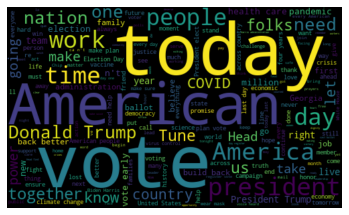

In [16]:
# Removendo stop words
stop_words = set(stopwords.words('english'))  
word_tokens = word_tokenize(' '.join([twts for twts in df_tweets['Tweets']]))  
filtered_sentence = [w for w in word_tokens if not w in stop_words] 

# word cloud
words = ' '.join([twts for twts in filtered_sentence])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(words)


plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

<AxesSubplot:>

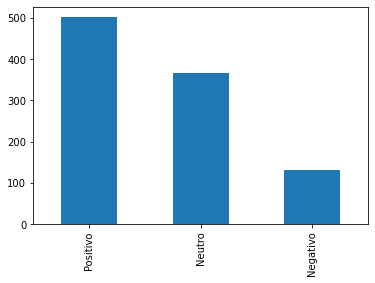

In [12]:
df_tweets['Sentimento'].value_counts().plot(kind='bar')

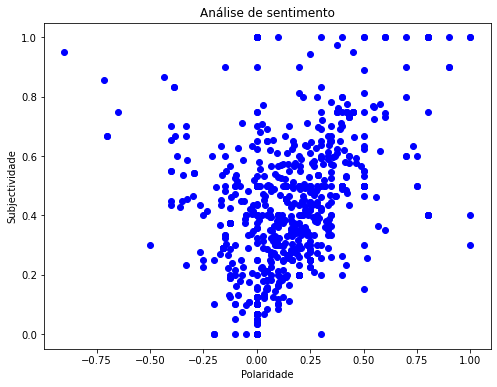

In [13]:
plt.figure(figsize=(8,6)) 
for i in range(0, df_tweets.shape[0]):
    plt.scatter(df_tweets["Polarity"][i], df_tweets["Subjectivity"][i], color='Blue') 
# plt.scatter(x,y,color)   
plt.title('Análise de sentimento') 
plt.xlabel('Polaridade') 
plt.ylabel('Subjectividade') 
plt.show()

In [17]:
# Criando coluna de tweets sem stopwords
stop_words = set(stopwords.words('english'))  
df_tweets['Tweets_no_stop'] = df_tweets['Tweets'].apply(lambda x: ' '.join(item for item in x.split() if item not in stop_words))

#### Preparação para realizar a classificação

In [18]:
X = df_tweets['Tweets_no_stop'].values
le = LabelEncoder()
y = le.fit_transform(df_tweets['Sentimento'].values)

In [19]:
y_cat = to_categorical(y) 

In [20]:
# Separando em treino e teste
sentence_train, sentence_test, y_train, y_test = train_test_split(X,y_cat, test_size=.2, 
                                                    random_state=42)
print(sentence_train.shape, sentence_test.shape)
print(y_train.shape, y_test.shape)

(799,) (200,)
(799, 3) (200, 3)


#### Transformano o array de texto em um array numerico 2D 

In [25]:
# Descrição da documentacao do keras
# This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.
# Sequences that are shorter than num_timesteps are padded with value until they are num_timesteps long.
# Sequences longer than num_timesteps are truncated so that they fit the desired length

max_words = 5000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(sentence_train)

vocab_size = len(tokenizer.word_index) + 1

X_train = tokenizer.texts_to_sequences(sentence_train)
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = tokenizer.texts_to_sequences(sentence_test)
X_test = pad_sequences(X_test, maxlen=max_len)

print(X_train.shape)
print(sentence_train[0])
print(X_train[0])

(799, 200)
You deserve president get every single day work make life better. If elect me, that’s exactly I’ll do.
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  38 268   4   8  23 348   7  27  11  83  49  39 121 200  93 596
  77 221]


In [26]:
# Funcao para checar overfit
def funcCheckFit(history):
    
    fig, axs = plt.subplots(2)

    fig.tight_layout(pad=3.0)

    x=history.history['accuracy']
    x2=history.history['val_accuracy']

    axs[0].plot(x,label='acc')
    axs[0].plot(x2,label='val_acc')
    axs[0].legend()
    axs[0].set_title('Acurácia')
    axs[0].set(xlabel='Época')

    x=history.history['loss']
    x2=history.history['val_loss']
    axs[1].plot(x,label='loss')
    axs[1].plot(x2,label='val_loss')
    axs[1].legend()
    axs[1].set_title('Loss')
    axs[1].set(xlabel='Época')

In [27]:
model = Sequential()
model.add(layers.Embedding(vocab_size, 40, input_length=max_len)) #The embedding layer
model.add(layers.LSTM(40,dropout=0.50)) #Our LSTM layer
model.add(layers.Dense(3,activation='softmax'))

model.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/70
25/25 [==============================] - 1s 25ms/step - loss: 1.0497 - accuracy: 0.5069 - val_loss: 0.9751 - val_accuracy: 0.4850
Epoch 2/70
25/25 [==============================] - 0s 12ms/step - loss: 0.9089 - accuracy: 0.6008 - val_loss: 0.9024 - val_accuracy: 0.5900
Epoch 3/70
25/25 [==============================] - 0s 12ms/step - loss: 0.8167 - accuracy: 0.6521 - val_loss: 0.8631 - val_accuracy: 0.6250
Epoch 4/70
25/25 [==============================] - 0s 11ms/step - loss: 0.6852 - accuracy: 0.7247 - val_loss: 0.8415 - val_accuracy: 0.6450
Epoch 5/70
25/25 [==============================] - 0s 11ms/step - loss: 0.5120 - accuracy: 0.7935 - val_loss: 0.9300 - val_accuracy: 0.6500
Epoch 6/70
25/25 [==============================] - 0s 12ms/step - loss: 0.3697 - accuracy: 0.8561 - val_loss: 1.0488 - val_accuracy: 0.6650
Epoch 7/70
25/25 [==============================] - 0s 12ms/step - loss: 0.2998 - accuracy: 0.8773 - val_loss: 0.8064 - val_accuracy: 0.6700
Epoch 8/70
25

#### Checando metricas e overfit

In [28]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

7/7 - 0s - loss: 1.0258 - accuracy: 0.6850
[1.0257564783096313, 0.6850000023841858]


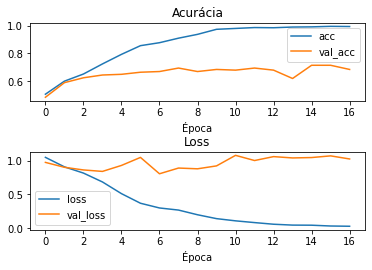

In [29]:
funcCheckFit(history)

#### Trocando parametros para melhorar o modelo

Embedding Lyaer:
- input_dim: the size of the vocabulary
- output_dim: the size of the dense vector
- input_length: the length of the sequence

In [71]:
model = Sequential()
model.add(layers.Embedding(vocab_size, 256, input_length=max_len)) #The embedding layer
model.add(layers.GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(layers.Dense(3,activation='softmax'))

model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100,validation_data=(X_test, y_test), batch_size=1024, callbacks=[early_stopping])

Epoch 1/100
1/1 [==============================] - 0s 105ms/step - loss: 1.1085 - accuracy: 0.2553 - val_loss: 1.0871 - val_accuracy: 0.4950
Epoch 2/100
1/1 [==============================] - 0s 35ms/step - loss: 1.0837 - accuracy: 0.4756 - val_loss: 1.0711 - val_accuracy: 0.4850
Epoch 3/100
1/1 [==============================] - 0s 38ms/step - loss: 1.0646 - accuracy: 0.4919 - val_loss: 1.0567 - val_accuracy: 0.4800
Epoch 4/100
1/1 [==============================] - 0s 32ms/step - loss: 1.0473 - accuracy: 0.5119 - val_loss: 1.0432 - val_accuracy: 0.4800
Epoch 5/100
1/1 [==============================] - 0s 41ms/step - loss: 1.0300 - accuracy: 0.5081 - val_loss: 1.0304 - val_accuracy: 0.4800
Epoch 6/100
1/1 [==============================] - 0s 35ms/step - loss: 1.0131 - accuracy: 0.5081 - val_loss: 1.0182 - val_accuracy: 0.4800
Epoch 7/100
1/1 [==============================] - 0s 33ms/step - loss: 0.9988 - accuracy: 0.5081 - val_loss: 1.0078 - val_accuracy: 0.4800
Epoch 8/100
1/1 [==

1/1 [==============================] - 0s 32ms/step - loss: 0.2169 - accuracy: 0.8836 - val_loss: 0.7821 - val_accuracy: 0.7000
Epoch 60/100
1/1 [==============================] - 0s 40ms/step - loss: 0.2048 - accuracy: 0.8899 - val_loss: 0.7799 - val_accuracy: 0.7100
Epoch 61/100
1/1 [==============================] - 0s 40ms/step - loss: 0.1998 - accuracy: 0.8974 - val_loss: 0.7824 - val_accuracy: 0.7200


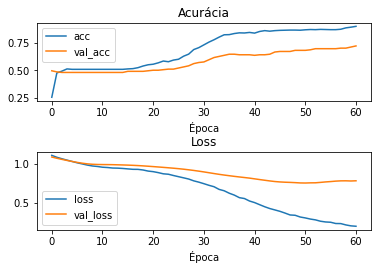

In [72]:
funcCheckFit(history)

In [73]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

7/7 - 0s - loss: 0.7824 - accuracy: 0.7200
[0.7824428677558899, 0.7200000286102295]
